
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits: using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, loss

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [13]:
train_episodes = 2500          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
            feed_dict = {model.states: states, model.actions: actions, model.nextQs: nextQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 11.0 Training q_loss: 0.0283 Explore P: 0.9989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 30.0 Training q_loss: 0.5078 Explore P: 0.9959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 13.0 Training q_loss: 2.2129 Explore P: 0.9947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 31.0 Training q_loss: 17.7604 Explore P: 0.9916
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 35 Total reward: 35.0 Training q_loss: 1187.6968 Explore P: 0.9299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 10.0 Training q_loss: 2488.3564 Explore P: 0.9290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 15.0 Training q_loss: 1083.0636 Explore P: 0.9276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 14.0 Training q_loss: 1703.4631 Explore P: 0.9264
-------------------------------------------------------------------------------
--------------------------------------------------------

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 28.0 Training q_loss: 1910083.2500 Explore P: 0.8422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 27.0 Training q_loss: 2125992.5000 Explore P: 0.8400
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 29.0 Training q_loss: 3724011.7500 Explore P: 0.8376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 76 Total reward: 24.0 Training q_loss: 2791880.7500 Explore P: 0.8356
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 107 Total reward: 35.0 Training q_loss: 1982442752.0000 Explore P: 0.7410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 42.0 Training q_loss: 1833095552.0000 Explore P: 0.7379
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 34.0 Training q_loss: 2358817024.0000 Explore P: 0.7355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 20.0 Training q_loss: 2474058240.0000 Explore P: 0.7340
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 142 Total reward: 141.0 Training q_loss: 108813828096.0000 Explore P: 0.6296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 68.0 Training q_loss: 48308125696.0000 Explore P: 0.6254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 43.0 Training q_loss: 114092244992.0000 Explore P: 0.6227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 43.0 Training q_loss: 45283143680.0000 Explore P: 0.6201
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 176 Total reward: 174.0 Training q_loss: 4653081165824.0000 Explore P: 0.4453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 48.0 Training q_loss: 1748158382080.0000 Explore P: 0.4432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 154.0 Training q_loss: 4031741952000.0000 Explore P: 0.4366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 192.0 Training q_loss: 3535672442880.0000 Explore P: 0.4285
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 210 Total reward: 173.0 Training q_loss: 26991321415680.0000 Explore P: 0.2463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 199.0 Training q_loss: 48790958505984.0000 Explore P: 0.2417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 199.0 Training q_loss: 14284735119360.0000 Explore P: 0.2371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 199.0 Training q_loss: 47258556956672.0000 Explore P: 0.2326
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 243 Total reward: 198.0 Training q_loss: 475624812576768.0000 Explore P: 0.1349
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 169.0 Training q_loss: 161065350463488.0000 Explore P: 0.1328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 198.0 Training q_loss: 565852210462720.0000 Explore P: 0.1304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 199.0 Training q_loss: 358883642048512.0000 Explore P: 0.1280
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 276 Total reward: 199.0 Training q_loss: 2210661543182336.0000 Explore P: 0.0750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Training q_loss: 2289969188044800.0000 Explore P: 0.0738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Training q_loss: 4759974278332416.0000 Explore P: 0.0725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Training q_loss: 5195325048356864.0000 Explore P: 0.0713
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 309 Total reward: 199.0 Training q_loss: 11922469510184960.0000 Explore P: 0.0437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 310 Total reward: 199.0 Training q_loss: 14677410783952896.0000 Explore P: 0.0431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 199.0 Training q_loss: 21293367669293056.0000 Explore P: 0.0424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Training q_loss: 9245839448866816.0000 Explore P: 0.0418
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 342 Total reward: 199.0 Training q_loss: 37518180008067072.0000 Explore P: 0.0275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 343 Total reward: 199.0 Training q_loss: 28822655792578560.0000 Explore P: 0.0272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 199.0 Training q_loss: 22125558385082368.0000 Explore P: 0.0268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 Training q_loss: 43744362168844288.0000 Explore P: 0.0265
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 375 Total reward: 199.0 Training q_loss: 29534563801759744.0000 Explore P: 0.0191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 376 Total reward: 199.0 Training q_loss: 19623269636243456.0000 Explore P: 0.0189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 377 Total reward: 199.0 Training q_loss: 20860516570234880.0000 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 378 Total reward: 199.0 Training q_loss: 33909015910023168.0000 Explore P: 0.0185
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 408 Total reward: 199.0 Training q_loss: 16944123797831680.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 199.0 Training q_loss: 20362510817296384.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 199.0 Training q_loss: 13238354074140672.0000 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 199.0 Training q_loss: 60249882832666624.0000 Explore P: 0.0144
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 441 Total reward: 199.0 Training q_loss: 42307064248139776.0000 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 199.0 Training q_loss: 45366257783930880.0000 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 199.0 Training q_loss: 43691456761692160.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 199.0 Training q_loss: 34045078326476800.0000 Explore P: 0.0123
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 474 Total reward: 199.0 Training q_loss: 35943750224052224.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 475 Total reward: 199.0 Training q_loss: 22800643492151296.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 476 Total reward: 199.0 Training q_loss: 27484940983599104.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 477 Total reward: 199.0 Training q_loss: 31673545561997312.0000 Explore P: 0.0112
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 507 Total reward: 199.0 Training q_loss: 18027506749669376.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 199.0 Training q_loss: 30382508457590784.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 199.0 Training q_loss: 33736789868937216.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 199.0 Training q_loss: 20252735748177920.0000 Explore P: 0.0106
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 540 Total reward: 199.0 Training q_loss: 17326369444724736.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 199.0 Training q_loss: 26905429636284416.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 199.0 Training q_loss: 27959616474185728.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 543 Total reward: 199.0 Training q_loss: 29955474891735040.0000 Explore P: 0.0103
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 573 Total reward: 199.0 Training q_loss: 35342016715948032.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 574 Total reward: 199.0 Training q_loss: 33126962494963712.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 575 Total reward: 199.0 Training q_loss: 27038889302556672.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 576 Total reward: 199.0 Training q_loss: 9005513480077312.0000 Explore P: 0.0102
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 606 Total reward: 199.0 Training q_loss: 132975288450547712.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 607 Total reward: 199.0 Training q_loss: 50572999392231424.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 608 Total reward: 199.0 Training q_loss: 165023638628597760.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 199.0 Training q_loss: 98524848963190784.0000 Explore P: 0.0101
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 639 Total reward: 199.0 Training q_loss: 105317949627170816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 640 Total reward: 199.0 Training q_loss: 199428147735691264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 199.0 Training q_loss: 312169355628511232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 199.0 Training q_loss: 164663308052332544.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 672 Total reward: 199.0 Training q_loss: 135525030145556480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 673 Total reward: 199.0 Training q_loss: 100392206254211072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 199.0 Training q_loss: 75030699249238016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 675 Total reward: 199.0 Training q_loss: 92939510282715136.0000 Explore P: 0.0100
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 705 Total reward: 199.0 Training q_loss: 134405976416583680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 706 Total reward: 199.0 Training q_loss: 28044635351810048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 707 Total reward: 199.0 Training q_loss: 59627915733630976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 Total reward: 199.0 Training q_loss: 13889065241804800.0000 Explore P: 0.0100
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 738 Total reward: 199.0 Training q_loss: 5506788560470016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 199.0 Training q_loss: 30239086614675456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 199.0 Training q_loss: 6932531408535552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 199.0 Training q_loss: 153216113180672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 771 Total reward: 197.0 Training q_loss: 812211802996736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 772 Total reward: 199.0 Training q_loss: 13803625457385472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 773 Total reward: 186.0 Training q_loss: 12164562858016768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 774 Total reward: 199.0 Training q_loss: 91276787580928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-

-------------------------------------------------------------------------------
Episode: 804 Total reward: 162.0 Training q_loss: 28834271531630592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 805 Total reward: 193.0 Training q_loss: 6304355934273536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 806 Total reward: 190.0 Training q_loss: 9116511541133312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 807 Total reward: 176.0 Training q_loss: 12234834965430272.0000 Explore P: 0.0100
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 837 Total reward: 188.0 Training q_loss: 22813483296882688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 838 Total reward: 199.0 Training q_loss: 26097260672581632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 839 Total reward: 199.0 Training q_loss: 22026136334630912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 840 Total reward: 199.0 Training q_loss: 8662938835484672.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 870 Total reward: 199.0 Training q_loss: 59557564169322496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 871 Total reward: 191.0 Training q_loss: 48853165637894144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 872 Total reward: 150.0 Training q_loss: 78559332710481920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 199.0 Training q_loss: 115343958074195968.0000 Explore P: 0.0100
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 903 Total reward: 199.0 Training q_loss: 121367812915593216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 199.0 Training q_loss: 128314553149685760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 199.0 Training q_loss: 93201829705285632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 127.0 Training q_loss: 112942856607367168.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 936 Total reward: 199.0 Training q_loss: 119121287321747456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 199.0 Training q_loss: 123825496281579520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 199.0 Training q_loss: 98328706396717056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 199.0 Training q_loss: 141118022457753600.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 969 Total reward: 199.0 Training q_loss: 161947686130417664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 199.0 Training q_loss: 242235399580155904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 199.0 Training q_loss: 135558702689157120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 199.0 Training q_loss: 164629807307423744.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1002 Total reward: 199.0 Training q_loss: 129585837699497984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1003 Total reward: 199.0 Training q_loss: 160784437187969024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1004 Total reward: 199.0 Training q_loss: 120852339530661888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1005 Total reward: 199.0 Training q_loss: 132940542165123072.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1035 Total reward: 199.0 Training q_loss: 235095360047939584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1036 Total reward: 199.0 Training q_loss: 143925238852222976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1037 Total reward: 199.0 Training q_loss: 221859404713033728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 199.0 Training q_loss: 190282581814542336.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1068 Total reward: 199.0 Training q_loss: 173418341187190784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 199.0 Training q_loss: 182168495239200768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1070 Total reward: 199.0 Training q_loss: 133443379756269568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 199.0 Training q_loss: 141776767361744896.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1101 Total reward: 199.0 Training q_loss: 154883547260256256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 199.0 Training q_loss: 287912119075078144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 151.0 Training q_loss: 189400515791028224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 199.0 Training q_loss: 195696645789188096.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1134 Total reward: 14.0 Training q_loss: 105354534158598144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1135 Total reward: 9.0 Training q_loss: 103289917609607168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1136 Total reward: 10.0 Training q_loss: 64730444255461376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1137 Total reward: 10.0 Training q_loss: 123804785949278208.0000 Explore P: 0.0100
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1168 Total reward: 10.0 Training q_loss: 59577308133982208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 9.0 Training q_loss: 70482208623689728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1170 Total reward: 10.0 Training q_loss: 95174087277543424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 11.0 Training q_loss: 71346308799004672.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1201 Total reward: 10.0 Training q_loss: 53644364865339392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1202 Total reward: 8.0 Training q_loss: 105252846512898048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1203 Total reward: 11.0 Training q_loss: 80589915938619392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1204 Total reward: 7.0 Training q_loss: 70252496592830464.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1234 Total reward: 9.0 Training q_loss: 35880631384670208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1235 Total reward: 7.0 Training q_loss: 73017450509107200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1236 Total reward: 9.0 Training q_loss: 28684304158556160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1237 Total reward: 8.0 Training q_loss: 41471203482796032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 1268 Total reward: 9.0 Training q_loss: 79695007962890240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward: 11.0 Training q_loss: 22926428051865600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1270 Total reward: 7.0 Training q_loss: 83434558678106112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1271 Total reward: 11.0 Training q_loss: 50894464809435136.0000 Explore P: 0.0100
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1302 Total reward: 11.0 Training q_loss: 110945310267670528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1303 Total reward: 12.0 Training q_loss: 30281980453060608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1304 Total reward: 8.0 Training q_loss: 67484888386764800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1305 Total reward: 9.0 Training q_loss: 113500652600033280.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1335 Total reward: 10.0 Training q_loss: 102770183617118208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 9.0 Training q_loss: 94631091742179328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1337 Total reward: 11.0 Training q_loss: 43703319461363712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1338 Total reward: 9.0 Training q_loss: 96195396140793856.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1368 Total reward: 11.0 Training q_loss: 86105452810600448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1369 Total reward: 9.0 Training q_loss: 132235136736428032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1370 Total reward: 13.0 Training q_loss: 85091402442080256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1371 Total reward: 9.0 Training q_loss: 113713889136345088.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1403 Total reward: 9.0 Training q_loss: 151237944659673088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1404 Total reward: 12.0 Training q_loss: 100290355399753728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1405 Total reward: 11.0 Training q_loss: 142663394640527360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 9.0 Training q_loss: 207498099227099136.0000 Explore P: 0.0100
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1436 Total reward: 199.0 Training q_loss: 675208647508230144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 199.0 Training q_loss: 371065245726146560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1438 Total reward: 199.0 Training q_loss: 263488873445720064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1439 Total reward: 199.0 Training q_loss: 387120932990222336.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1469 Total reward: 199.0 Training q_loss: 481069803537170432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1470 Total reward: 199.0 Training q_loss: 501507147717148672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1471 Total reward: 199.0 Training q_loss: 642216839044136960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1472 Total reward: 199.0 Training q_loss: 417596921411010560.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1502 Total reward: 18.0 Training q_loss: 223193936951246848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 17.0 Training q_loss: 205355838259331072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1504 Total reward: 16.0 Training q_loss: 293227931377860608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1505 Total reward: 16.0 Training q_loss: 108628725167292416.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1535 Total reward: 13.0 Training q_loss: 352175464162263040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1536 Total reward: 18.0 Training q_loss: 161449882240942080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 14.0 Training q_loss: 199411878399574016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1538 Total reward: 13.0 Training q_loss: 210444068835033088.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1569 Total reward: 17.0 Training q_loss: 229204795221606400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 15.0 Training q_loss: 40556422693388288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1571 Total reward: 20.0 Training q_loss: 160480009906028544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1572 Total reward: 14.0 Training q_loss: 65434410870112256.0000 Explore P: 0.0100
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1603 Total reward: 19.0 Training q_loss: 306827928140775424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1604 Total reward: 18.0 Training q_loss: 310242186622926848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1605 Total reward: 23.0 Training q_loss: 215349454063009792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1606 Total reward: 22.0 Training q_loss: 278836131624124416.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1636 Total reward: 199.0 Training q_loss: 319437161847848960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1637 Total reward: 199.0 Training q_loss: 168659534603091968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 199.0 Training q_loss: 328663301355470848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 199.0 Training q_loss: 263397201663754240.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1669 Total reward: 132.0 Training q_loss: 549735335483932672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1670 Total reward: 137.0 Training q_loss: 322388388495753216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 137.0 Training q_loss: 736337439563448320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 121.0 Training q_loss: 791187745346158592.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1702 Total reward: 159.0 Training q_loss: 532614599409664000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1703 Total reward: 199.0 Training q_loss: 623515864242585600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 199.0 Training q_loss: 649472928592691200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 192.0 Training q_loss: 985578240041025536.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1735 Total reward: 199.0 Training q_loss: 605454530330492928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1736 Total reward: 199.0 Training q_loss: 1008202753366818816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1737 Total reward: 199.0 Training q_loss: 1338173958163267584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1738 Total reward: 199.0 Training q_loss: 610402263936008192.0000 Explore P: 0.0100
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1768 Total reward: 199.0 Training q_loss: 241299921343348736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 199.0 Training q_loss: 584274775283597312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1770 Total reward: 199.0 Training q_loss: 101673437948280832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1771 Total reward: 199.0 Training q_loss: 303899688157839360.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1801 Total reward: 199.0 Training q_loss: 65255516892299264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1802 Total reward: 199.0 Training q_loss: 31694335351193600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1803 Total reward: 199.0 Training q_loss: 66451553615085568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1804 Total reward: 199.0 Training q_loss: 66721101467615232.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1834 Total reward: 199.0 Training q_loss: 1443361761691435008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1835 Total reward: 199.0 Training q_loss: 1281119062847389696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1836 Total reward: 199.0 Training q_loss: 1471332100551475200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1837 Total reward: 199.0 Training q_loss: 1185625653341323264.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1867 Total reward: 199.0 Training q_loss: 4513792100159979520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 199.0 Training q_loss: 2920460388413734912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 199.0 Training q_loss: 2427255206321324032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1870 Total reward: 199.0 Training q_loss: 2087604244751319040.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1900 Total reward: 199.0 Training q_loss: 4444593236354269184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1901 Total reward: 199.0 Training q_loss: 4528972507448868864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1902 Total reward: 199.0 Training q_loss: 2749560822207348736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1903 Total reward: 199.0 Training q_loss: 3994000452030038016.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1933 Total reward: 199.0 Training q_loss: 1765112811400200192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1934 Total reward: 199.0 Training q_loss: 6253333294755086336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 199.0 Training q_loss: 2740097325627080704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1936 Total reward: 199.0 Training q_loss: 5085086247324483584.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1966 Total reward: 199.0 Training q_loss: 2967349336658149376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 199.0 Training q_loss: 1950895367000162304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 199.0 Training q_loss: 2422562765571883008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 199.0 Training q_loss: 1478107566079737856.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1999 Total reward: 199.0 Training q_loss: 1070673842961121280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2000 Total reward: 199.0 Training q_loss: 696837690494025728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2001 Total reward: 199.0 Training q_loss: 988419859123535872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2002 Total reward: 199.0 Training q_loss: 844369679672672256.0000 Explore P: 0.0100
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2032 Total reward: 199.0 Training q_loss: 7415538061934592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2033 Total reward: 199.0 Training q_loss: 24421411678322688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2034 Total reward: 199.0 Training q_loss: 1496666850983936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2035 Total reward: 199.0 Training q_loss: 32488532786282496.0000 Explore P: 0.0100
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2065 Total reward: 199.0 Training q_loss: 24104857556221952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2066 Total reward: 199.0 Training q_loss: 184086146597257216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2067 Total reward: 199.0 Training q_loss: 39793602141880320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2068 Total reward: 199.0 Training q_loss: 12623383476830208.0000 Explore P: 0.0100
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2098 Total reward: 199.0 Training q_loss: 33826782318690304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2099 Total reward: 199.0 Training q_loss: 26177935190786048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2100 Total reward: 199.0 Training q_loss: 1709142238560256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2101 Total reward: 199.0 Training q_loss: 19217721644285952.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2131 Total reward: 199.0 Training q_loss: 48438825847881728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2132 Total reward: 199.0 Training q_loss: 50899142028820480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2133 Total reward: 199.0 Training q_loss: 27908630917414912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2134 Total reward: 199.0 Training q_loss: 144497869661929472.0000 Explore P: 0.0100
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2164 Total reward: 199.0 Training q_loss: 712998174960123904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2165 Total reward: 199.0 Training q_loss: 1290301496767807488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2166 Total reward: 199.0 Training q_loss: 2347479040656408576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2167 Total reward: 199.0 Training q_loss: 2272853399772856320.0000 Explore P: 0.0100
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2197 Total reward: 199.0 Training q_loss: 2066887109221810176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2198 Total reward: 199.0 Training q_loss: 1538057887828410368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2199 Total reward: 199.0 Training q_loss: 739752453959843840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2200 Total reward: 199.0 Training q_loss: 1320596203208966144.0000 Explore P: 0.0100
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2230 Total reward: 199.0 Training q_loss: 1202658050528247808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2231 Total reward: 199.0 Training q_loss: 1170488539322777600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2232 Total reward: 199.0 Training q_loss: 1133359199883886592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2233 Total reward: 199.0 Training q_loss: 669212873163014144.0000 Explore P: 0.0100
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2263 Total reward: 199.0 Training q_loss: 972339089250451456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2264 Total reward: 199.0 Training q_loss: 403064744946171904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2265 Total reward: 199.0 Training q_loss: 653234632749219840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2266 Total reward: 199.0 Training q_loss: 683380424084291584.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2296 Total reward: 199.0 Training q_loss: 402851611489075200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2297 Total reward: 199.0 Training q_loss: 622008365081427968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2298 Total reward: 199.0 Training q_loss: 476342796890931200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2299 Total reward: 199.0 Training q_loss: 801301396895825920.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2329 Total reward: 199.0 Training q_loss: 430092561823039488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2330 Total reward: 199.0 Training q_loss: 567539795991986176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2331 Total reward: 199.0 Training q_loss: 765782773272150016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2332 Total reward: 199.0 Training q_loss: 1097290820446322688.0000 Explore P: 0.0100
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2362 Total reward: 199.0 Training q_loss: 750251759212953600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2363 Total reward: 199.0 Training q_loss: 605738754086273024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2364 Total reward: 199.0 Training q_loss: 770015755600134144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2365 Total reward: 199.0 Training q_loss: 574243861983920128.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2395 Total reward: 199.0 Training q_loss: 599058327594336256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2396 Total reward: 199.0 Training q_loss: 613249036979273728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2397 Total reward: 199.0 Training q_loss: 843058993092886528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2398 Total reward: 199.0 Training q_loss: 1035393675921719296.0000 Explore P: 0.0100
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2428 Total reward: 199.0 Training q_loss: 347458146962243584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2429 Total reward: 199.0 Training q_loss: 672366203791998976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2430 Total reward: 199.0 Training q_loss: 549734510850211840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2431 Total reward: 199.0 Training q_loss: 406030952440004608.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2461 Total reward: 199.0 Training q_loss: 385550658587066368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2462 Total reward: 199.0 Training q_loss: 401733167645458432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2463 Total reward: 199.0 Training q_loss: 322955805215162368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2464 Total reward: 199.0 Training q_loss: 270071340323569664.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2494 Total reward: 199.0 Training q_loss: 516573240156487680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2495 Total reward: 199.0 Training q_loss: 709506950664028160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2496 Total reward: 199.0 Training q_loss: 300665474704736256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2497 Total reward: 199.0 Training q_loss: 307009141400928256.0000 Explore P: 0.0100
--------------------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0.5,0,'Episode')

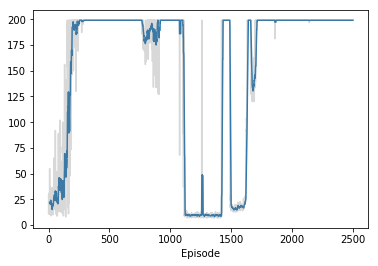

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0.5,0,'Episode')

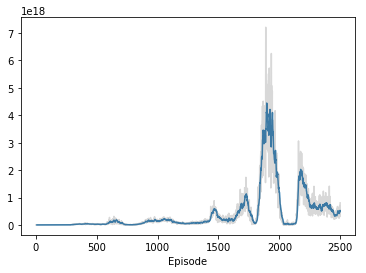

In [19]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.